In [2]:
import clip
import numpy as np
import torch
import PIL.Image

from embedding import get_delta_t
from manipulator import Manipulator
from mapper import get_delta_s
from wrapper import Generator

/opt/conda/lib/python3.8/site-packages/clip/clip.py:24: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [3]:
device = torch.device('cuda:2')
ckpt = 'pretrained/ffhq.pkl'
G = Generator(ckpt, device)
model, preprocess = clip.load("ViT-B/32", device=device)
fs3 = np.load('tensor/fs3.npy')
expdir = 'test2'
num_images = 1
lst_alpha = [0]

In [4]:
manipulator = Manipulator(G, device, lst_alpha, num_images)

In [5]:
manipulator.set_real_img_projection(expdir, mode='w')

  0%|                                                                                 | 0/3 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [04:30<00:00, 90.02s/it]


In [79]:
lst_alpha = [-3, -1.5, 0, 1.5, 3]
manipulator.set_alpha(lst_alpha)

# --------------------------------------

classnames=['neutral face', 'face with smile']
beta_threshold = 0.10
delta_t = get_delta_t(classnames, model)
delta_s, num_channel = get_delta_s(fs3, delta_t, manipulator, beta_threshold=beta_threshold)
print(f'{num_channel} channels will be manipulated under the beta threshold {beta_threshold}')

105 channels will be manipulated under the beta threshold 0.1


In [80]:
styles = manipulator.manipulate(delta_s)

In [81]:
all_imgs = manipulator.synthesis_from_styles(styles, 0, manipulator.num_images)

In [82]:
lst = []
for imgs in all_imgs:
    lst.append((imgs.permute(0,2,3,1)*127.5+128).clamp(0,255).to(torch.uint8).numpy())

-3


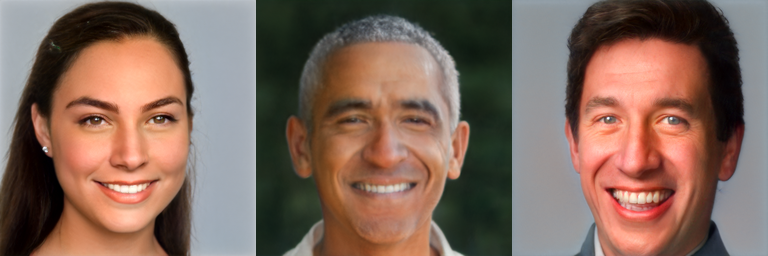

-1.5


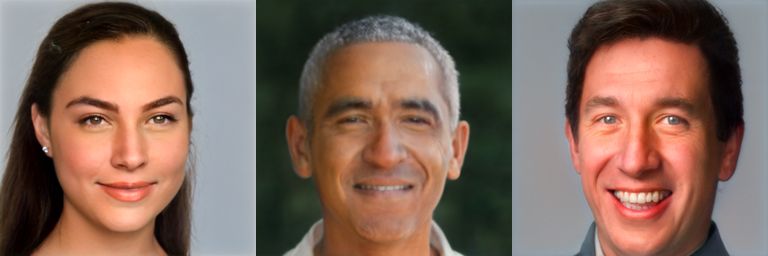

0


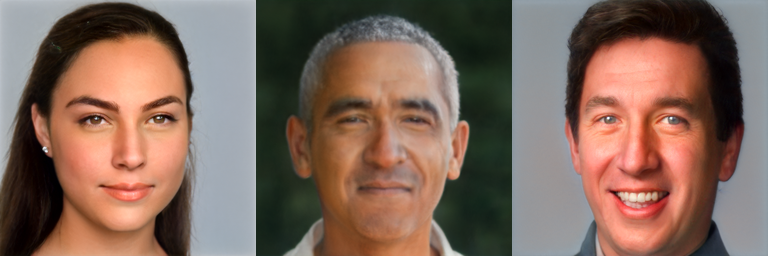

1.5


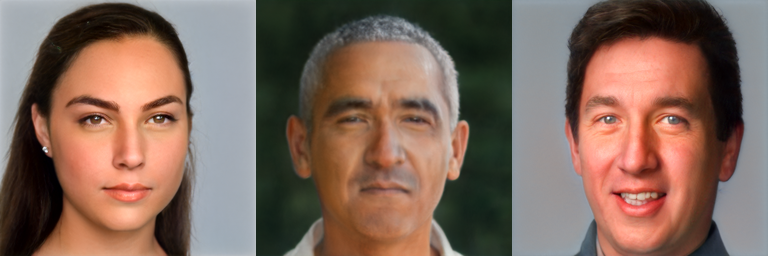

3


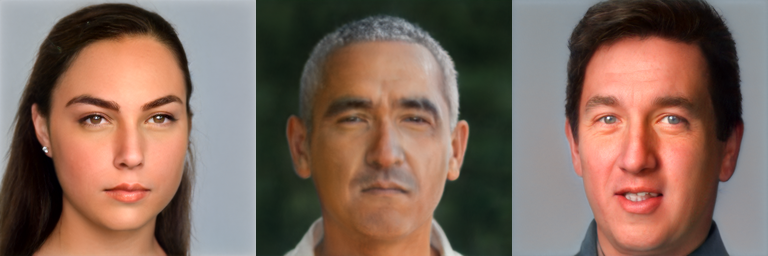

In [83]:
H,W = (256,256)
gw, gh = (manipulator.num_images, 1)

for i, alpha in enumerate(lst_alpha):
    print(alpha)
    imgs = lst[i]
    imgs_ = []    
    for img in imgs:
        imgs_.append( np.asarray( PIL.Image.fromarray(img, 'RGB').resize((H,W),PIL.Image.LANCZOS)))
    imgs_ = np.stack(imgs_)
    imgs_ = imgs_.reshape(gh,gw,H,W,3)
    imgs_ = imgs_.transpose(0,2,1,3,4)
    imgs_ = imgs_.reshape(gh*H, gw*W, 3)
    display(PIL.Image.fromarray(imgs_, 'RGB'))